In [1]:
from dbcp.helpers import get_sql_engine
import pandas as pd
import numpy as np

/app/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
eng = get_sql_engine()

In [3]:
q = """
select
    county_id_fips,
    gap_status,
    manager_type,
    intersection_area_padus_km2,
    county_land_area_sq_meters / 1000000 as county_land_area_km2,
    county_area_coast_clipped_km2
from data_warehouse.protected_area_by_county
"""
pad = pd.read_sql(q, eng)

In [4]:
pad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263032 entries, 0 to 263031
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   county_id_fips                 263032 non-null  object 
 1   gap_status                     263032 non-null  object 
 2   manager_type                   263032 non-null  object 
 3   intersection_area_padus_km2    263032 non-null  float64
 4   county_land_area_km2           263032 non-null  float64
 5   county_area_coast_clipped_km2  263032 non-null  float64
dtypes: float64(3), object(3)
memory usage: 12.0+ MB


In [5]:
county_areas = pad.groupby('county_id_fips')[['county_land_area_km2', 'county_area_coast_clipped_km2']].first()

In [6]:
is_developable = pad['gap_status'].str.match('^[34]')
is_federally_managed = pad['manager_type'] == 'Federal'

In [22]:
pad.loc[is_developable, 'gap_status'].value_counts()

4 - no known mandate for biodiversity protection                                             155247
3 - managed for multiple uses - subject to extractive (e.g. mining or logging) or OHV use     66494
Name: gap_status, dtype: int64

In [7]:
federal_developable = pad.loc[is_developable & is_federally_managed, :].groupby('county_id_fips')['intersection_area_padus_km2'].sum().rename('fed_dev')
un_developable = pad.loc[~is_developable, :].groupby('county_id_fips')['intersection_area_padus_km2'].sum().rename('protected')

In [24]:
areas = pd.concat([county_areas, federal_developable, un_developable], axis=1, join='outer')

In [25]:
areas['fed_dev'].sum() * 247.1  # acres

443549442.0

In [26]:
areas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3110 entries, 01001 to 56045
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   county_land_area_km2           3110 non-null   float64
 1   county_area_coast_clipped_km2  3110 non-null   float64
 2   fed_dev                        1689 non-null   float64
 3   protected                      2696 non-null   float64
dtypes: float64(4)
memory usage: 121.5+ KB


In [27]:
areas.loc[:,['fed_dev', 'protected']].fillna(0, inplace=True)

In [28]:
areas['unprotected'] = areas['county_area_coast_clipped_km2'] - areas['protected']
areas['fed_fraction_of_developable'] = areas['fed_dev'] / areas['unprotected']

In [29]:
areas['fed_fraction_of_developable'].describe()

count    1514.000000
mean        0.144890
std         0.223433
min         0.000000
25%         0.000000
50%         0.025016
75%         0.205633
max         1.158841
Name: fed_fraction_of_developable, dtype: float64

In [30]:
areas['fed_fraction_of_developable'].gt(1).agg(['sum', 'mean'])

sum     1.000000
mean    0.000322
Name: fed_fraction_of_developable, dtype: float64

In [31]:
areas.iloc[areas['fed_fraction_of_developable'].argmax(),:]

county_land_area_km2             4420.814008
county_area_coast_clipped_km2    4491.000000
fed_dev                          1160.000000
protected                        3490.000000
unprotected                      1001.000000
fed_fraction_of_developable         1.158841
Name: 02020, dtype: float64

In [32]:
# would need A LOT of maximally wrong rounding to create that error. is it possible? [Yes! There are like 550 areas that got rounded down to 0.]
max_rounding_error = 5 # km2
diff = 1160 - 1001
diff / max_rounding_error # minimum errors needed

31.8

<AxesSubplot: >

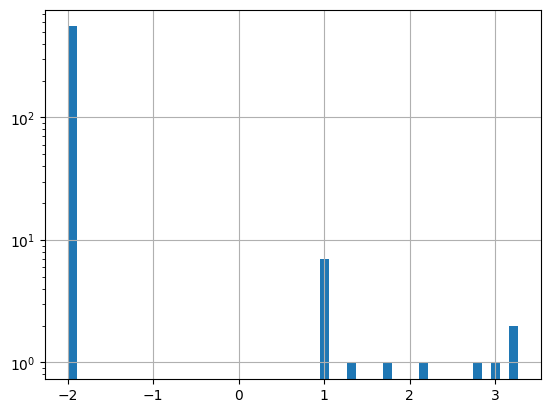

In [33]:
pad.query("county_id_fips == '02020'")['intersection_area_padus_km2'].add(1e-2).transform(np.log10).hist(bins=50, log=True)

In [42]:
# how many zeros overall?
pad['intersection_area_padus_km2'].eq(0.0).agg(['mean', 'sum'])

mean         0.957956
sum     251973.000000
Name: intersection_area_padus_km2, dtype: float64

In [43]:
# how many nulls overall?
pad['intersection_area_padus_km2'].isna().agg(['mean', 'sum'])

mean    0.0
sum     0.0
Name: intersection_area_padus_km2, dtype: float64

In [36]:
areas['error_check'] = (areas['fed_fraction_of_developable'] * areas['unprotected'])

In [41]:
(areas['error_check'].sum() - areas['fed_dev'].sum()) * 247.1  # acres

-21737387.0

Error because of some combination of missing data and rounding.

/app/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='error_check', ylabel='fed_dev'>

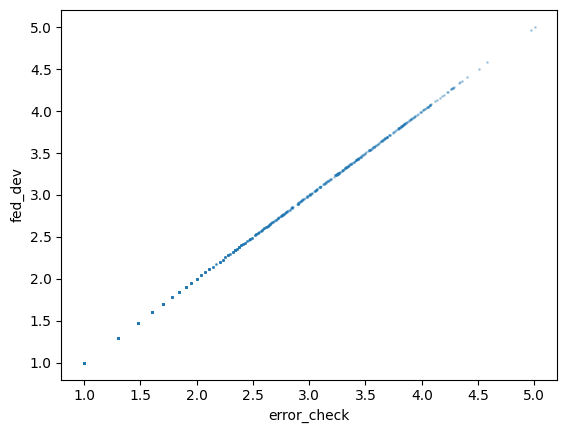

In [37]:
areas.transform(np.log10).plot.scatter('error_check', 'fed_dev', s=1, alpha=0.3)

/app/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='county_land_area_km2', ylabel='county_area_coast_clipped_km2'>

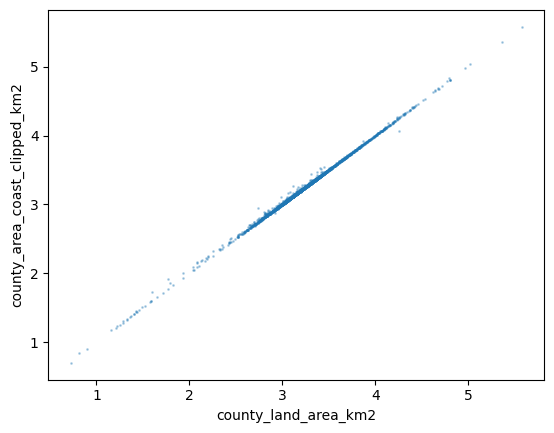

In [34]:
areas.transform(np.log10).plot.scatter('county_land_area_km2', 'county_area_coast_clipped_km2', s=1, alpha=0.3)

In [44]:
pad.loc[pad['gap_status'].str.startswith('3') & pad['manager_type'].eq('Federal'), 'intersection_area_padus_km2'].sum() * 247.1

438745818.0

In [45]:
pad.loc[pad['gap_status'].str.startswith('4') & pad['manager_type'].eq('Federal'), 'intersection_area_padus_km2'].sum() * 247.1

4803624.0

In [46]:
pad['gap_status'].value_counts()

4 - no known mandate for biodiversity protection                                             155247
3 - managed for multiple uses - subject to extractive (e.g. mining or logging) or OHV use     66494
2 - managed for biodiversity - disturbance events suppressed                                  38256
1 - managed for biodiversity - disturbance events proceed or are mimicked                      3035
Name: gap_status, dtype: int64

In [47]:
total_area = 9_147_593  # 50 states + DC per wikipedia

In [48]:
not_gap_4 = pad.loc[~pad['gap_status'].str.startswith('4'), 'intersection_area_padus_km2'].sum()

In [50]:
(total_area - not_gap_4) * 247.1

1576506154.3

<AxesSubplot: >

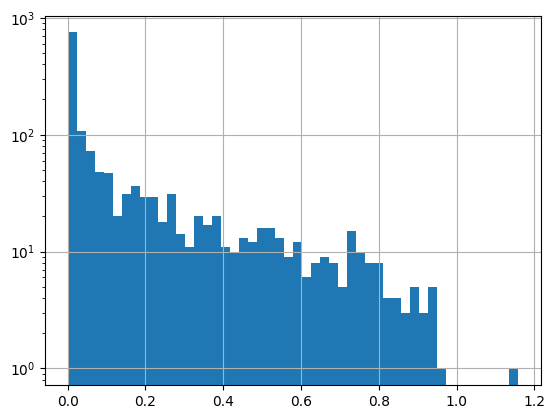

In [52]:
areas['fed_fraction_of_developable'].hist(bins=50, log=True)

In [53]:
areas['fed_fraction_of_developable'].gt(0.1).agg(['mean', 'sum'])

mean      0.168167
sum     523.000000
Name: fed_fraction_of_developable, dtype: float64